# Data preparation and questions answers
In this notebook we solve the proposed questions

## Question 1
Which are the factors that dertermine the price of an airbnb? Location, commodities, etc.

In [1]:
# Import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import listings_preprocessing, calendar_preprocessing
import folium
import json
import plotly.graph_objects as go

In [3]:
seattle_path = 'Datasets/airbnb seattle/listings.csv'
boston_path = 'Datasets/airbnb boston/listings.csv'
col_of_interest = ['id','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','host_name','host_since','host_location','host_about','host_response_rate','host_acceptance_rate','host_is_superhost','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','zipcode','latitude','longitude','is_location_exact','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price','weekly_price','monthly_price','security_deposit','cancellation_policy','calculated_host_listings_count','reviews_per_month']
seattle = listings_preprocessing(seattle_path, col_of_interest)
boston =  listings_preprocessing(boston_path, col_of_interest)

<AxesSubplot:>

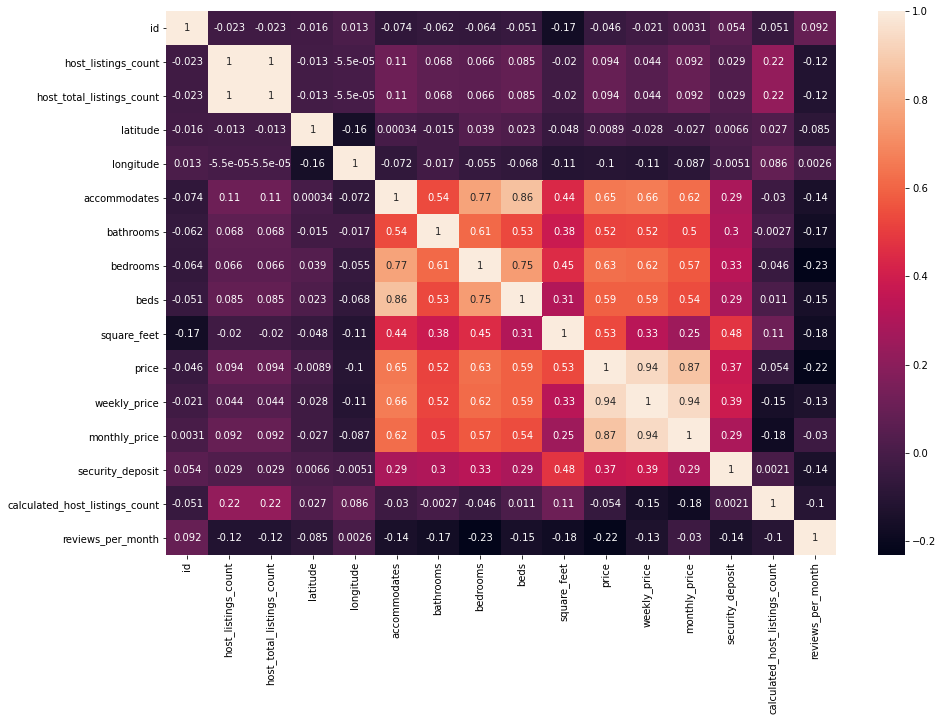

In [3]:
# Let's look at the correlation matrix to see if price or price per bedroom have any relationship with any other column.
plt.figure(figsize=(15,10))
sns.heatmap(seattle.corr(), annot=True)

<AxesSubplot:>

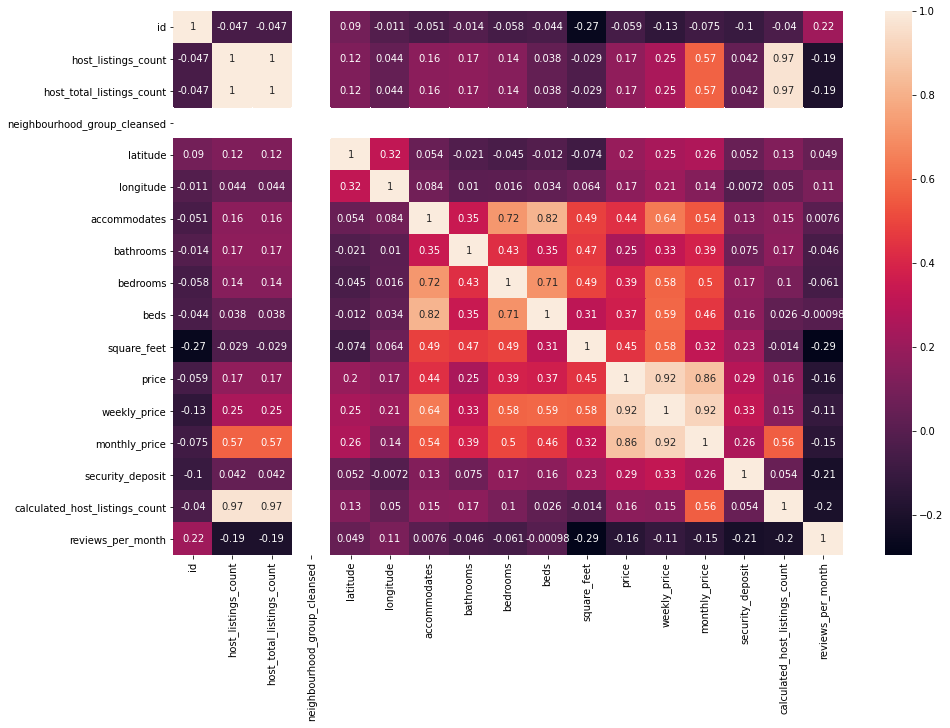

In [4]:
# Let's look at the correlation matrix to see if price or price per bedroom have any relationship with any other column.
plt.figure(figsize=(15,10))
sns.heatmap(boston.corr(), annot=True)

# Notes
What do we see from the heat map above?
* The price of an airbnb has a relationship with square feet, bed, bedrooms and bathrooms.
* The price column has not a clear relationship with latitude and longitude, I thought that the airbnbs in the downtown are were more experiensive than those on the lateral areas of the city.

The heat map was done for numeric fields of the dataframe. Can we do the same for the categorical fields? Of course :)


<AxesSubplot:>

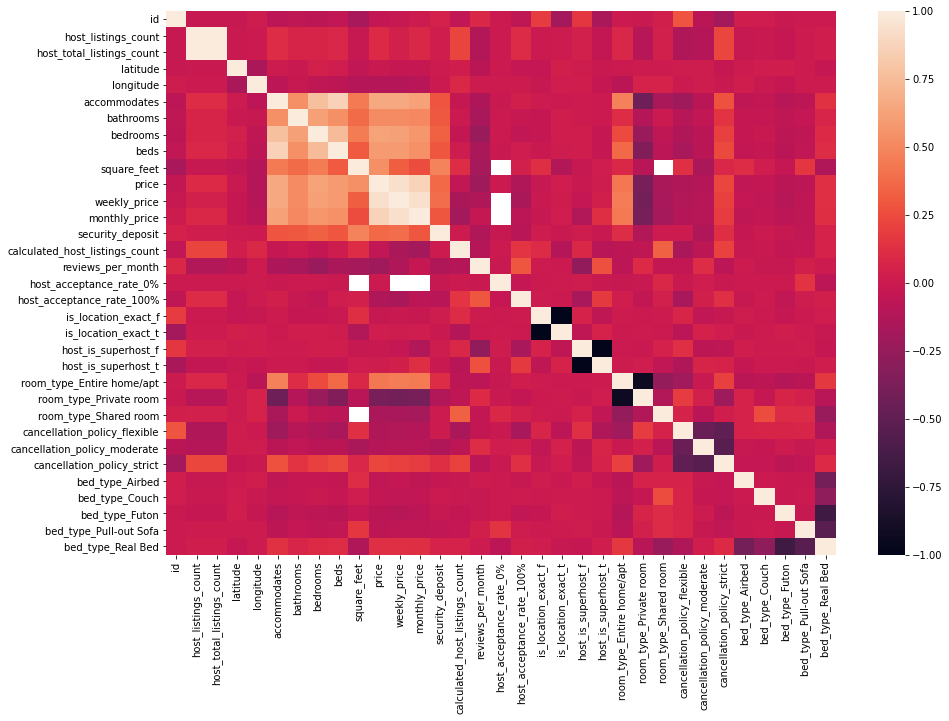

In [10]:
# Let's create a dummy dataframe and look at the correlation matrix
from utils import get_dummy_df
# The result has many columns (28626), it will be useful to check how many unique values there are in the categorical features.
#Let's look at the categorical columns of the dataframe
seattle_cat = seattle.select_dtypes(include=['object'])
unique_cat = seattle_cat.nunique().sort_values()
# Let's pick the categorical columns with less than 6 unique values to convert to a dummy variables
cat_col = unique_cat[(unique_cat <= 5) & (unique_cat != 1)].index.values
seattle_dummy = get_dummy_df(seattle, cat_col, False)
plt.figure(figsize=(15,10))
sns.heatmap(seattle_dummy.corr())

<AxesSubplot:>

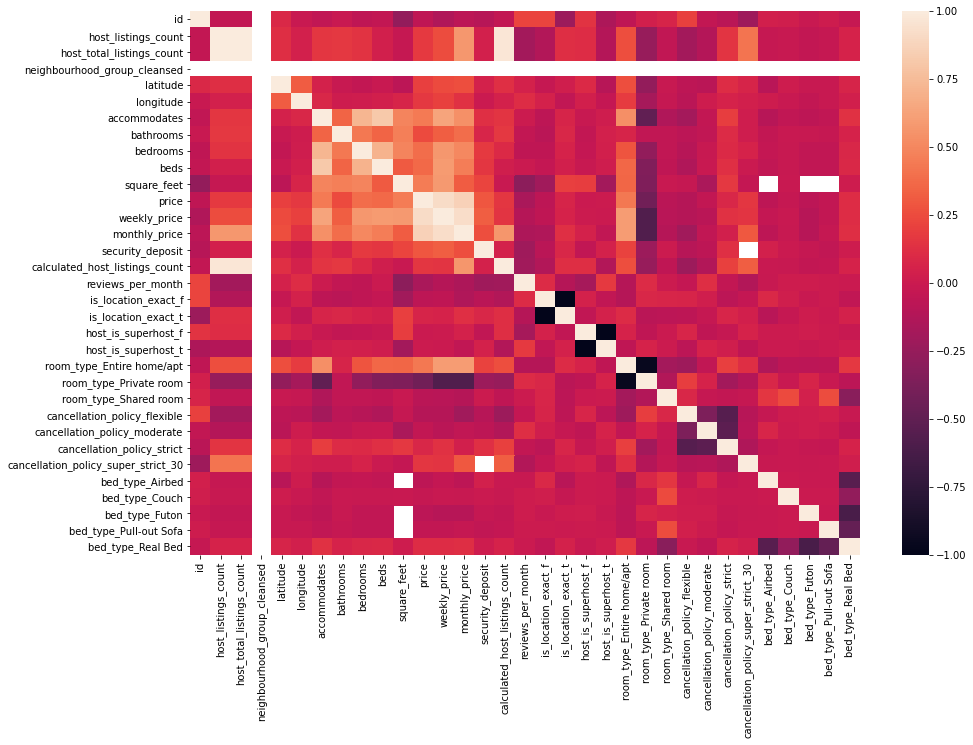

In [12]:
# Do the same with boston
boston_cat = boston.select_dtypes(include=['object'])
unique_cat = boston_cat.nunique().sort_values()
cat_col = unique_cat[(unique_cat <= 5) & (unique_cat != 1)].index.values
boston_dummy = get_dummy_df(boston, cat_col, False)
plt.figure(figsize=(15,10))
sns.heatmap(boston_dummy.corr())

# Bonus: is the postal code a factor that influences price?
Let's find it!

In [ ]:
seattle_zip = seattle.groupby(by='zipcode')['price'].mean()
seattle_zip = pd.DataFrame(seattle_zip)
seattle_zip['zipcode'] = seattle_zip.index
seattle_zip.loc[seattle_zip['zipcode'] == '99\n98122', 'zipcode'] = '98122'
seattle_zip['GEOID10'] = seattle_zip['zipcode'].astype('int').astype('str')
seattle_zip.reset_index(drop=True, inplace=True)

with open('Datasets/airbnb seattle/zip-codes.geojson') as geo:
    seatle_zipcodes = json.load(geo)
m = folium.Map(location=[47.35, -121.9], zoom_start=10)

# Complete the map in case the zipcode is not in seattle zip
json_zipcodes = [zipcode['properties']['GEOID10'] for zipcode in seatle_zipcodes['features']]
for zipcode in json_zipcodes:
    if not zipcode in seattle_zip['zipcode'].unique():
        seattle_zip = seattle_zip.append({'zipcode':zipcode, 'GEOID10':zipcode, 'price':0}, ignore_index=True)
        
folium.Choropleth(
    geo_data=seatle_zipcodes,
    name="choropleth",
    data=seattle_zip,
    columns=["GEOID10", "price"],
    key_on='feature.properties.GEOID10',
    fill_color="Spectral",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Airbnb price",
).add_to(m)

folium.LayerControl().add_to(m)
m

In [ ]:
# extra question: is the postal code a factor that influences price?
boston_zip = boston.groupby(by='zipcode')['price'].mean()
boston_zip = pd.DataFrame(boston_zip)
boston_zip['zipcode'] = boston_zip.index
boston_zip.loc[boston_zip['zipcode'] == '02108 02111', 'zipcode'] = '02108'
boston_zip.loc[boston_zip['zipcode'] == '02134-1704', 'zipcode'] = '02134'
boston_zip['ZIP5'] = boston_zip['zipcode'].astype('str')
boston_zip.reset_index(drop=True, inplace=True)

with open('Datasets/airbnb boston/zip-codes.geojson') as geo:
    boston_zipcodes = json.load(geo)
m = folium.Map(location=[42.364758, -71.067421], zoom_start=11)

# Complete the map in case the zipcode is not in seattle zip
json_zipcodes = [zipcode['properties']['ZIP5'] for zipcode in boston_zipcodes['features']]
for zipcode in json_zipcodes:
    if not zipcode in boston_zip['zipcode'].unique():
        boston_zip = boston_zip.append({'zipcode':zipcode, 'ZIP5':zipcode, 'price':0}, ignore_index=True)
        
folium.Choropleth(
    geo_data=boston_zipcodes,
    name="choropleth",
    data=boston_zip,
    columns=["ZIP5", "price"],
    key_on='feature.properties.ZIP5',
    fill_color="Spectral",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Airbnb price",
).add_to(m)

folium.LayerControl().add_to(m)
m

# Question 2
Which are the most common amenities offered in Airbnb

In [14]:
# Let's analyze the most common amenities Airbnbs offer
seattle_path = 'Datasets/airbnb seattle/listings.csv'
boston_path = 'Datasets/airbnb boston/listings.csv'
col_of_interest = ['id','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','host_name','host_since','host_location','host_about','host_response_rate','host_acceptance_rate','host_is_superhost','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','zipcode','latitude','longitude','is_location_exact','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price','weekly_price','monthly_price','security_deposit','cancellation_policy','calculated_host_listings_count','reviews_per_month']
seattle = listings_preprocessing(seattle_path, col_of_interest)
boston =  listings_preprocessing(boston_path, col_of_interest)

C:\Users\uib00068\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

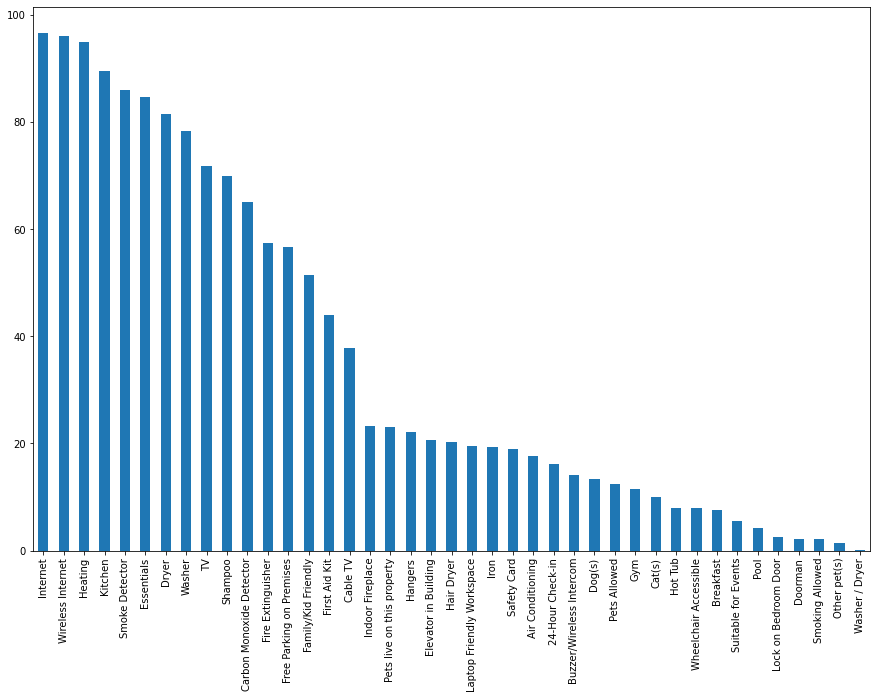

In [15]:
# Amenities field is a string separaed by , and other symbols, let's make a list of unique amenities.
# Ammenities can be a factor that influences price in an airbnb, let's create a set of all possible ammenities
amenities = []
for index, entry in seattle.amenities.iteritems():
    amenities.extend(entry.replace('{','').replace('"','').replace('}','').split(','))
seattle_unique_amenities = set(amenities)
seattle_unique_amenities.discard('')

# Let's create a column per amenity indicating if it is available (1) or not (0)
# Create amenities columns
seattle.reset_index(drop=True, inplace=True)
for amenity in seattle_unique_amenities:
    seattle[amenity] = 0
    for index, row in seattle.iterrows():
        if amenity in row['amenities']:
            seattle[amenity].iloc[index] = 1
        else:
            seattle[amenity].iloc[index] = 0
seattle_amen_perc = seattle[list(seattle_unique_amenities)].mean().sort_values(ascending=False)*100

# Plot the percentage of amenities
plt.figure(figsize=(15,10))
seattle_amen_perc.plot(kind='bar')

In [16]:
# Now, let's repeat the process for Boston
# Amenities field is a string separaed by , and other symbols, let's make a list of unique amenities.
# Ammenities can be a factor that influences price in an airbnb, let's create a set of all possible ammenities
amenities = []
for index, entry in boston.amenities.iteritems():
    amenities.extend(entry.replace('{','').replace('"','').replace('}','').split(','))
boston_unique_amenities = set(amenities)
boston_unique_amenities.discard('')

# Let's create a column per amenity indicating if it is available (1) or not (0)
# Create amenities columns
boston.reset_index(drop=True, inplace=True)
for amenity in boston_unique_amenities:
    boston[amenity] = 0
    for index, row in boston.iterrows():
        if amenity in row['amenities']:
            boston[amenity].iloc[index] = 1
        else:
            boston[amenity].iloc[index] = 0

C:\Users\uib00068\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
boston_amen_perc = boston[list(boston_unique_amenities)].mean().sort_values(ascending=False)*100
seattle_amen_perc = seattle[list(seattle_unique_amenities)].mean().sort_values(ascending=False)*100
amenities_perc = pd.concat([boston_amen_perc, seattle_amen_perc], axis=1, names=['Boston', 'Seattle'])
amenities_perc.columns = ['Boston', 'Seattle']

In [21]:
fig = go.Figure(data=[
    go.Bar(name='Boston', x=amenities_perc.index, y=amenities_perc.Boston.to_list()),
    go.Bar(name='Seattle', x=amenities_perc.index, y=amenities_perc.Seattle.to_list()),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(title="Most common amenities in Airbnb", xaxis_title="Amenity", yaxis_title="Percentage", legend_title="City")
fig.show()

<Figure size 1440x720 with 0 Axes>

# Question 3
How is airbnb demand over the year?

In [23]:
# Let's analyze the most common amenities Airbnbs offer
seattle_path = 'Datasets/airbnb seattle/calendar.csv'
boston_path = 'Datasets/airbnb boston/calendar.csv'
seattle = calendar_preprocessing(seattle_path)
boston = calendar_preprocessing(boston_path)

Text(0, 0.5, 'Number of airbnbs available')

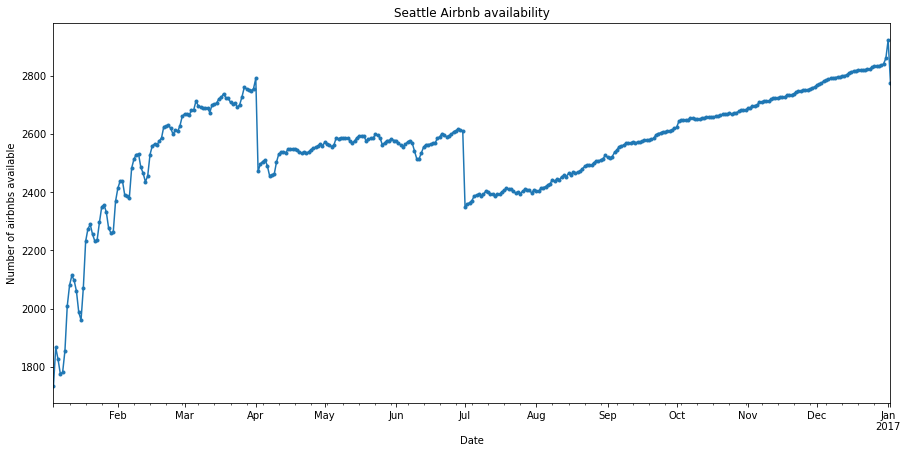

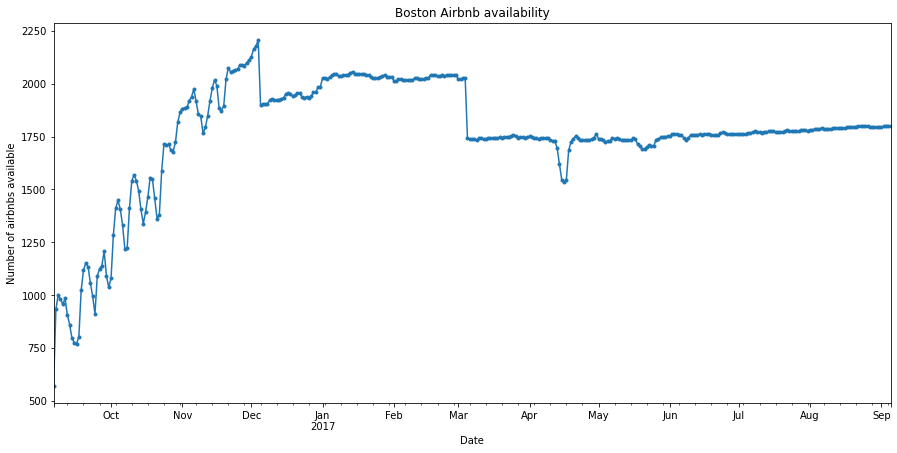

In [24]:
# Let's plot the availability of Seattle and Boston Airbnb
seattle_aval = seattle.groupby(by='date')['available'].sum()
plt.figure(figsize=(15,7))
ax = seattle_aval.plot(marker='.', title='Seattle Airbnb availability' )
ax.set_xlabel('Date')
ax.set_ylabel('Number of airbnbs available')

boston_aval = boston.groupby(by='date')['available'].sum()
plt.figure(figsize=(15,7))
ax = boston_aval.plot(marker='.', title='Boston Airbnb availability' )
ax.set_xlabel('Date')
ax.set_ylabel('Number of airbnbs available')

In [25]:
# Let's focus only on the firsts months, before the avaibility drops
# To indentify when the drops occur we calculate the difference between rows sorted by date

seattle_diff = seattle_aval.diff(periods=1).sort_values()
boston_diff = boston_aval.diff(periods=1).sort_values()

print(seattle_diff.index[0])
print(boston_diff.index[0])

2016-04-02 00:00:00
2016-12-05 00:00:00


Text(0, 0.5, 'Number of airbnbs available')

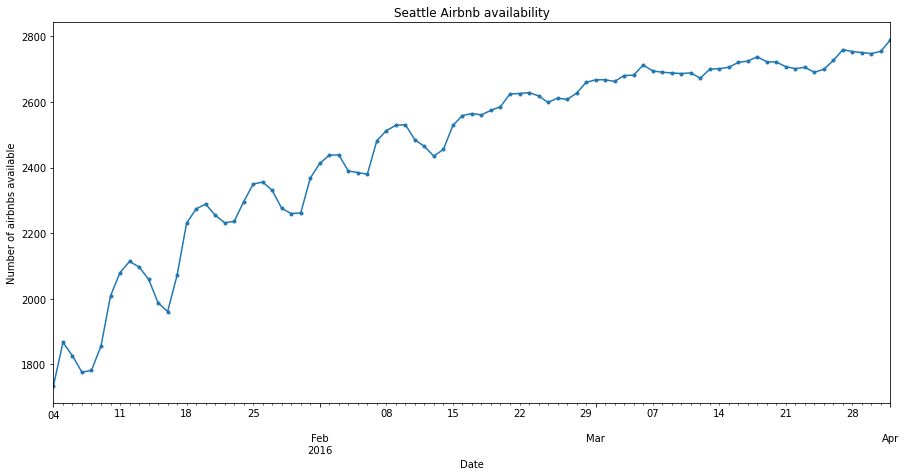

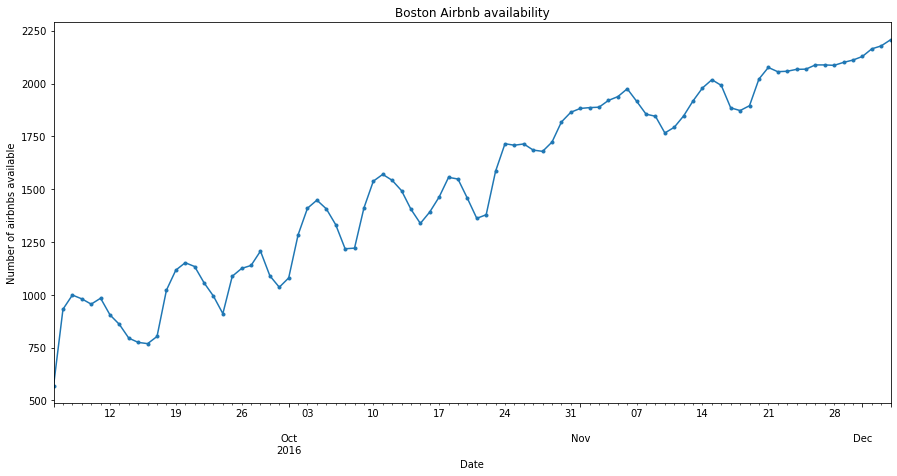

In [26]:
# Let's filter Seattle and Boston by the first element of seattle_diff and boston_diff and plot again availability
seattle_fil = seattle.loc[seattle['date']<pd.to_datetime(seattle_diff.index[0]), :]
boston_fil = boston.loc[boston['date']<pd.to_datetime(boston_diff.index[0]), :]

# Plot
seattle_aval = seattle_fil.groupby(by='date')['available'].sum()
plt.figure(figsize=(15,7))
ax = seattle_aval.plot(marker='.', title='Seattle Airbnb availability' )
ax.set_xlabel('Date')
ax.set_ylabel('Number of airbnbs available')

boston_aval = boston_fil.groupby(by='date')['available'].sum()
plt.figure(figsize=(15,7))
ax = boston_aval.plot(marker='.', title='Boston Airbnb availability' )
ax.set_xlabel('Date')
ax.set_ylabel('Number of airbnbs available')


In [27]:
# The period of the oscillatory component of both graphs is around 7-8 days.
# Let's group by day of the week and see how availability depends on the day of the week
seattle_aval_day = seattle_fil.groupby(by='day_of_week')['available'].sum().sort_values()
boston_aval_day = boston_fil.groupby(by='day_of_week')['available'].sum().sort_values()
print(seattle_aval_day, boston_aval_day)
# The numbers shows a trend where Saturdays, Fridays, and Sundays are less available than Tuesdays or Wednesdays
# I want to represent the availability per days of the week as a percentage of the total available Airbnb
# By looking at the grapahs of availability we can say that it is the result of 3 components:
# The availability function is the sum of 3 functions: a constant + an oscillatory + an exponential.
# When a listing ID is constant it does not contribute to analyze the availability thus we need to filter them

day_of_week
Saturday     29129
Sunday       29830
Friday       31897
Thursday     31923
Monday       31996
Wednesday    32229
Tuesday      32284
Name: available, dtype: int64 day_of_week
Monday       19194
Friday       19261
Saturday     19357
Thursday     19622
Tuesday      19914
Wednesday    20170
Sunday       20793
Name: available, dtype: int64


day_of_week
Saturday     29129
Sunday       29830
Friday       31897
Thursday     31923
Monday       31996
Wednesday    32229
Tuesday      32284
Name: available, dtype: int64 day_of_week
Monday       19194
Friday       19261
Saturday     19357
Thursday     19622
Tuesday      19914
Wednesday    20170
Sunday       20793
Name: available, dtype: int64


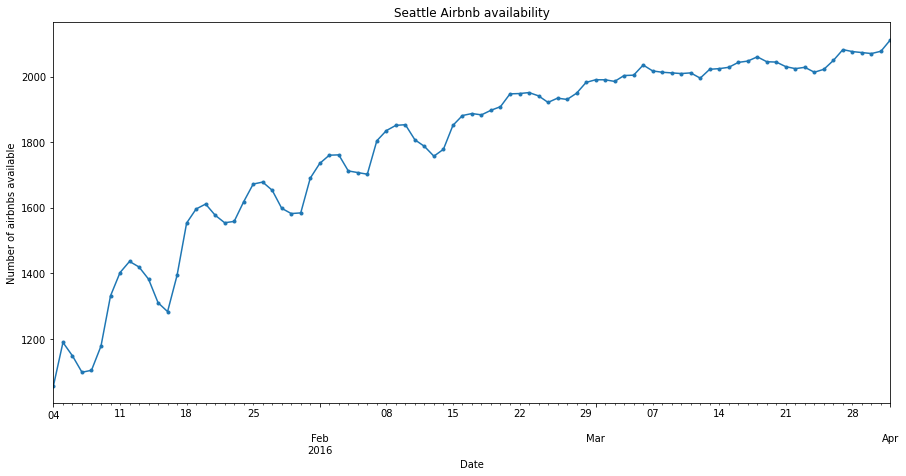

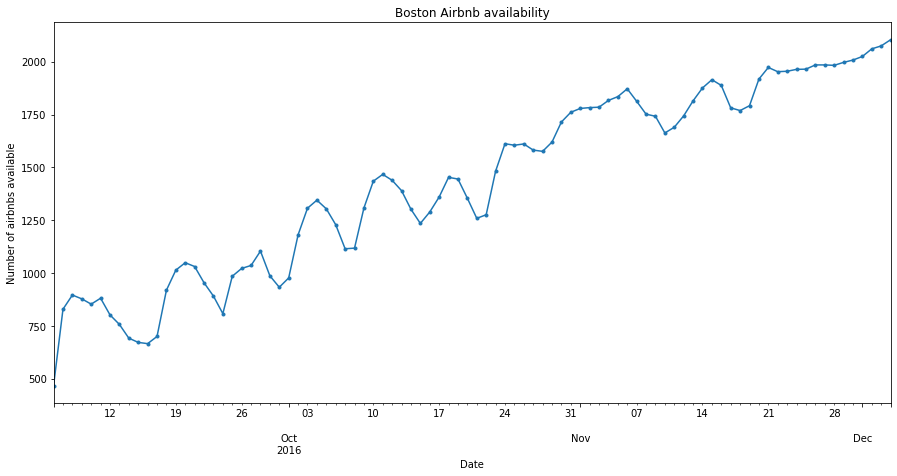

In [28]:
# Identify listing_id that were available always. Let's call them "inactive population"
# Include airbnb that we unavailable all year.

n_days = len(seattle['date'].unique())
seattle_aval_all_year = seattle.groupby('listing_id')['available'].sum()
seattle_inactive_ids = list(seattle_aval_all_year[seattle_aval_all_year.isin([n_days, 0])].index)

n_days = len(boston['date'].unique())
boston_aval_all_year = boston.groupby('listing_id')['available'].sum()
boston_inactive_ids = list(boston_aval_all_year[boston_aval_all_year.isin([n_days, 0])].index)

# Filter seattle_fil and boston_fil to include only active population
active_seattle_fil = seattle_fil.loc[~seattle_fil['listing_id'].isin(seattle_inactive_ids)]
active_boston_fil = boston_fil.loc[~boston_fil['listing_id'].isin(boston_inactive_ids)]

# Plot availability again
seattle_aval = active_seattle_fil.groupby(by='date')['available'].sum()
plt.figure(figsize=(15,7))
ax = seattle_aval.plot(marker='.', title='Seattle Airbnb availability' )
ax.set_xlabel('Date')
ax.set_ylabel('Number of airbnbs available')

boston_aval = active_boston_fil.groupby(by='date')['available'].sum()
plt.figure(figsize=(15,7))
ax = boston_aval.plot(marker='.', title='Boston Airbnb availability' )
ax.set_xlabel('Date')
ax.set_ylabel('Number of airbnbs available')

# Print availability per day
active_seattle_aval_day = active_seattle_fil.groupby(by='day_of_week')['available'].sum().sort_values()
active_boston_aval_day = active_boston_fil.groupby(by='day_of_week')['available'].sum().sort_values()
print(seattle_aval_day, boston_aval_day)

In [29]:
active_seatle_percentage = active_seattle_aval_day/active_seattle_aval_day.sum()*100
active_boston_percentage = active_boston_aval_day/active_boston_aval_day.sum()*100
perc_aval = pd.concat([active_seatle_percentage, active_boston_percentage], axis=1)
perc_aval.columns = ['Seattle', 'Boston']
fig = go.Figure(data=[
    go.Bar(name='Boston', x=perc_aval.index, y=perc_aval.Boston.to_list()),
    go.Bar(name='Seattle', x=perc_aval.index, y=perc_aval.Seattle.to_list()),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(title="Availability per day of the week", xaxis_title="Day", yaxis_title="Percentage", legend_title="City")
fig.show()

In [30]:
# Why are Sundays in Boston so available?
# The exponential component makes difficult to compare the availability per day.
# We can group by month and day of the week to find a clearer pattern.
active_seattle_fil['month'] = active_seattle_fil['date'].dt.month_name()
active_boston_fil['month'] = active_boston_fil['date'].dt.month_name()

active_seattle_aval_month_day = active_seattle_fil.groupby(by=['month','day_of_week'])['available'].sum().sort_values()
active_boston_aval_month_day = active_boston_fil.groupby(by=['month','day_of_week'])['available'].sum().sort_values()
print(active_seattle_aval_month_day, active_boston_aval_month_day)


<ipython-input-30-9fa4027dfa3f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-9fa4027dfa3f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



month     day_of_week
April     Friday          2112
January   Friday          5550
          Saturday        5603
          Thursday        5655
          Monday          5684
          Wednesday       5831
          Tuesday         5899
          Sunday          6033
February  Saturday        7297
          Thursday        7323
          Friday          7325
          Wednesday       7442
          Tuesday         7443
          Sunday          7478
March     Saturday        8093
          Friday          8096
          Monday          8147
          Sunday          8183
February  Monday          9351
March     Tuesday        10128
          Thursday       10131
          Wednesday      10142
Name: available, dtype: int64 month      day_of_week
December   Thursday       2025
           Friday         2061
           Saturday       2075
           Sunday         2104
September  Saturday       2361
           Sunday         2785
           Monday         2838
           Tuesday        

In [33]:
seattle_month_day = active_seattle_aval_month_day.to_frame()
months, days = [], []
for month, day in seattle_month_day.index:
    months.append(month)
    days.append(day)
seattle_month_day['month'] = months
seattle_month_day['day'] = days
valid_months = ['January', 'February', 'March']
valid_seattle_month_day = seattle_month_day.loc[seattle_month_day['month'].isin(valid_months), :]
valid_per_day = valid_seattle_month_day.groupby('day')['available'].sum().sort_values()
fig = go.Figure(data=[go.Bar(name='Seattle', x=valid_per_day.index, y=valid_per_day)])
fig.update_layout(title="Number of Airbnb available from Jan to Mar 2016 in Seattle", xaxis_title="Day", yaxis_title="Number of Airbnb available")
fig.show()

In [34]:
boston_month_day = active_boston_aval_month_day.to_frame()
months = []
days = []
for month, day in boston_month_day.index:
    months.append(month)
    days.append(day)
boston_month_day['month'] = months
boston_month_day['day'] = days
valid_months = ['September', 'October', 'November']
valid_boston_month_day = boston_month_day.loc[boston_month_day['month'].isin(valid_months), :]
valid_per_day = valid_boston_month_day.groupby('day')['available'].sum().sort_values()
fig = go.Figure(data=[go.Bar(name='boston', x=valid_per_day.index, y=valid_per_day)])
fig.update_layout(title="Number of Airbnb available from Oct to Nov 2016 in Boston", xaxis_title="Day", yaxis_title="Number of Airbnb available")
fig.show()